# Importazione librerie

Importiamo tutte le librerie necessarie per il Notebook:

In [1]:
import base64  # fornisce funzioni per codificare e decodificare dati binari in stringhe ASCII utilizzando la codifica base64
import datetime  # fornisce funzioni e classi per lavorare con date e tempi
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import preprocess_dataset as ut
import random
import seaborn as sns
import tensorflow as tf

from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator  # strumento di visualizzazione per l’esplorazione dei dati
from IPython.core.display import HTML  # funzioni utilizzate per visualizzare output HTML nel notebook
from keras_tuner import HyperModel, GridSearch, RandomSearch
from keras_tuner.tuners import BayesianOptimization
from lime import lime_tabular
from math import sqrt
from scipy.interpolate import BSpline
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.utils import check_random_state
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tfkan import DenseKAN



Impostiamo in seme casuale a 0 per poter rendere l'esperimento ripetibile:

In [2]:
#valore del seme causale
seed_value = 0

#impostazione dei semi casuali
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

#controllo che il seme sia stato correttamente impostato
check_random_state(seed_value)

RandomState(MT19937) at 0x1FF8AA06D40

# Caricamento del dataset e analisi

Il dataset che abbiamo scelto per il nostro task contiene 100.000 records, ognuno dei quali è relativo al ricovero ospedaliero di un paziente.
Gli attributi considerati sono in parte relativi all'identità del paziente, e in parte alla sua condizione clinica e sanitaria. 

Come prima cosa ci salviamo il nome del dataset in una variabile, usiamo un impostazione di pandas che permette di cambiare il tipo degli attributi nel dataset e poi carichiamo il dataset in un dataframe pandas: 

In [3]:
#variabile contenente il nome del dataset
DATASET_NAME = 'LengthOfStay'

#Consente che si possa cambiare il tipo degli attributi nel dataset
pd.set_option('future.no_silent_downcasting', True)    

#Carica il dataset in un Pandas Dataframe
df = pd.read_csv(f"datasets/{DATASET_NAME}.csv")

Eseguiamo un analisi grafica del dataset osservando la distribuzione dei vari attributi, gli estremi ed eventuali valori mancanti nei record

In [4]:
fsg = FeatureStatisticsGenerator() #Crea un oggetto FeatureStatisticsGenerator, che è una classe di Facets che genera statistiche dai tuoi dati
dataframes = [ {'table': df, 'name': DATASET_NAME}] #Crea un dizionario con dentro il dataframe
censusProto = fsg.ProtoFromDataFrames(dataframes) # Genera le statistiche dal DataFrame
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8") # codifica dei dati del dataset

# Impostazioni per la visualizzazione (mostra degli attributi evidentemente sbilanciati)
HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script> <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html"> <facets-overview id="elem"></facets-overview> <script> document.querySelector("#elem").protoInput = "{protostr}"; </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html)) #mostra l'analisi grafica

c:\Users\gobba\miniconda3\envs\kambinete\lib\site-packages\facets_overview\base_generic_feature_statistics_generator.py:121: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  flattened = x.ravel()


Osserviamo che non sono presenti valori mancanti in nessun attributo, ma sono presenti molti attributi sbilanciati nella distribuzione dei loro valori

## Pre-processing del dataset

Importando il dataset e visualizzando i record ci accorgiamo che ci sono degli attributi non numerici, come date e stringhe, questi non possono essere elaborati direttamente da Tensorflow ma vanno preprocessati e convertiti in valori numerici.

Gli attributi a cui dovremo dare una codifica numerica sono:
    
- **vdate** e **discharged**: sono la data di inizio e fine del ricovero; si potrebbero codificare come interi da 0 a 365 (o 366 a seconda dell'anno), tuttavia per il nostro scopo è opportuno eliminare queste colonne in quanto permettono di risalire algoritmicamente al target della predizione.

- **rcount**: è il numero di ricoveri pregressi del paziente; trasformeremo il valore 5+ in 5.

- **gender**: è il genere del paziente; trasformeremo M in 0 ed F in 1.

- **facid**: è un identificativo del reparto ospedaliero; trasformeremo le lettere in numeri incrementali.

In [5]:
dates = df["vdate"] # Date originali
encoded_dates = [datetime.datetime.strptime(str(date), "%m/%d/%Y").timetuple().tm_yday for date in dates] # Date codificate 
encoding_dict = dict(zip(dates, encoded_dates)) # Creazione dizionario di codifica per le date
df.replace({"vdate": encoding_dict}, inplace=True) # Sostituzione nella colonna

df.drop("discharged", axis=1, inplace=True) # Rimuove la colonna "discharged"

df.replace({"rcount": dict(zip(sorted(df["rcount"].unique()), range(6)))}, inplace=True) # Codifica del 5+ in 5 e conversione a interi

df.replace({"gender": {"M":0, "F":1}}, inplace=True) # Codifica binaria del genere, assegna 0 a maschio e 1 a femmina

keys = df["facid"].unique() # Estrazione dei valori unici dell'attributo
ints = {key: value for value, key in enumerate(keys)} # Creazione del dizionario di codifica
df.replace({"facid": ints}, inplace=True) # Codifica del facid

Separiamo adesso training set, validation set e test set, inoltre creiamo a parte dei dataset per addestrare i modelli di ML poiche essi possono essere allenati su attributi non in forma tensoriale, ma anche categorica

In [6]:
test_ratio = 0.20
val_ratio = 0.20

data_len = len(df)
train_bound = int(data_len*(1-val_ratio-test_ratio))
val_bound = int(data_len*(1-test_ratio))

df_features = df.iloc[:, 1:-1]
df_labels = df.iloc[:, -1]

x_train, y_train = df_features[:train_bound], df_labels[:train_bound]
xtree_train, ytree_train, xtree_test, ytree_test = x_train, y_train, df_features[val_bound:], df_labels[val_bound:]
x_val, y_val = df_features[train_bound:val_bound], df_labels[train_bound:val_bound]

# Creazione dei dataset di train e test
xtree_train.to_csv("datasets/x_train.csv")
ytree_train.to_csv("datasets/y_train.csv")
xtree_test.to_csv("datasets/x_test.csv")
ytree_test.to_csv("datasets/y_test.csv")
x_val.to_csv("datasets/x_val.csv")
y_val.to_csv("datasets/y_val.csv")
             
tensor_dataset = df.to_numpy()

A questo punto il dataset ha solamente valori numerici e può essere trattato come un tensore.
Sappiamo che le reti neurali necessitano che i tensori da esse elaborati contengano valori tra 0 e 1, dunque è opportuno standardizzare i dati

In [7]:
#divide le colonne del dataset in attributi e label
features1 = tensor_dataset[:, 1:-1]
labels = tensor_dataset[:, -1]

features1 = tf.convert_to_tensor(ut.standardize(features1), dtype=tf.float32)

#divide i dati in dati in train, validazione e test set
x_train, y_train = features1[:train_bound], labels[:train_bound]
x_val, y_val = features1[train_bound:val_bound], features1[train_bound:val_bound]
x_test, y_test = features1[val_bound:], labels[val_bound:]

print(tf.shape(x_train), tf.shape(x_val), tf.shape(x_test)) #stampa le dimensioni dei nuovi dataset creati

tf.Tensor([60000    25], shape=(2,), dtype=int32) tf.Tensor([20000    25], shape=(2,), dtype=int32) tf.Tensor([20000    25], shape=(2,), dtype=int32)


In [8]:
# Conversione dei dataset a tensori
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

Per cercare di dare una risposta alla domanda che guida il nostro progetto, dobbiamo valutare se l'architettura KAN recentemente introdotta possa costituire una valida alternativa agli approcci di apprendimento allo stato dell'arte dalle reti fully connected agli algoritmi più tradizionali.

Per farlo dobbiamo confrontare diversi modelli sia in termini di prestazioni che in termini di equità algoritmica.

Utilizzeremo le metriche tipiche di un task di regressione cioè **MSE**, **MAE** e **RMSE** (quest'ultima è stata definita da noi in quanto non presente nella suite di Tensorflow).

In [9]:
#definizamo una funzione per calcolare RMSE
class RootMeanSquaredError(tf.keras.metrics.Metric):
    def __init__(self, name='rmse', **kwargs):
        super(RootMeanSquaredError, self).__init__(name=name, **kwargs)
        self.mse = tf.keras.metrics.MeanSquaredError(name='mse')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.mse.update_state(y_true, y_pred, sample_weight)
        
    def result(self):
        return tf.sqrt(self.mse.result())
        
    def reset_states(self):
        self.mse.reset_states()


# Lista di metrics necessarie per valutare le performance.
METRICS = [
  tf.keras.metrics.MeanSquaredError(name='mse'),
  tf.keras.metrics.MeanAbsoluteError(name='mae'),
  tf.keras.metrics.RootMeanSquaredError(name='rmse')
]

#lista performance dei vari modelli
histories = []

#lista dei modelli addestrati di deep learning e machine learning
elenco_modelli = []
elenco_modelliML = []

#elenco nomi feature accorciati
features = [
    'vdate', 'rcount', 'gender', 'dialysis', 'asthma', 'irondef', 'pneum', 'subdep', 'psychmaj',
    'depress', 'psychother', 'fibrosis', 'malnutr', 'hemo', 'hematocrit', 'neutrophils', 'sodium',
    'glucose', 'bun', 'creatinine', 'bmi', 'pulse', 'respiration', 'secdiag', 'facid'
]

#parametro usato per la creazione dei modelli
numero_feature = len(features)


HIDDEN_UNITS_LAYER_01 = 8
HIDDEN_UNITS_LAYER_02 = 4
HIDDEN_UNITS_LAYER_03 = 1
LEARNING_RATE = 0.1 
EPOCH = 10

# Definizione architettura KAN Classica

In [10]:
# Creazione del modello KAN
kan = tf.keras.models.Sequential([
    DenseKAN(HIDDEN_UNITS_LAYER_01),
    DenseKAN(HIDDEN_UNITS_LAYER_02),
    DenseKAN(HIDDEN_UNITS_LAYER_03)
])
kan.build(input_shape=(None, numero_feature))
kan.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan (DenseKAN)            │ (None, 8)              │         1,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_1 (DenseKAN)          │ (None, 4)              │           292 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_2 (DenseKAN)          │ (None, 1)              │            37 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,137 (16.70 KB)

 Trainable params: 2,137 (16.70 KB)

 Non-trainable params: 0 (0.00 B)

Ora addestriamo la kan:

In [11]:
kan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0050089061837515795), loss='mse', metrics=METRICS)

kan_history = kan.fit(x_train, y_train, epochs=EPOCH, batch_size=128, validation_data=(x_test, y_test), verbose=1)

histories.append(('KAN', kan_history))
elenco_modelli.append(('KAN', kan))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 5.5671 - mae: 1.6419 - mse: 5.5671 - rmse: 2.2386 - val_loss: 0.7466 - val_mae: 0.5991 - val_mse: 0.7466 - val_rmse: 0.8640
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.7108 - mae: 0.6020 - mse: 0.7108 - rmse: 0.8431 - val_loss: 0.6405 - val_mae: 0.5514 - val_mse: 0.6405 - val_rmse: 0.8003
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6331 - mae: 0.5657 - mse: 0.6331 - rmse: 0.7957 - val_loss: 0.6005 - val_mae: 0.5306 - val_mse: 0.6005 - val_rmse: 0.7749
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5999 - mae: 0.5503 - mse: 0.5999 - rmse: 0.7745 - val_loss: 0.5763 - val_mae: 0.5197 - val_mse: 0.5763 - val_rmse: 0.7591
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5796 - mae: 0.5412 - mse: 0.5796 - rmse: 0.7613 - val_loss: 0.5598 - val_mae: 0.5117 - val_mse: 0.5598 - val_rmse: 0.7482
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5615 - mae: 0.5

# Definizione architettura MLP Classica

In [12]:
# MLP
mlp = tf.keras.models.Sequential([
    Dense(HIDDEN_UNITS_LAYER_01),
    Dense(HIDDEN_UNITS_LAYER_02),
    Dense(HIDDEN_UNITS_LAYER_03)
    ])
mlp.build(input_shape=(None, numero_feature))
mlp.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 249 (996.00 B)

 Trainable params: 249 (996.00 B)

 Non-trainable params: 0 (0.00 B)

Addestriamo la MLP:

In [13]:
mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss='mse', metrics=METRICS)

mlp_history = mlp.fit(x_train, y_train, epochs=EPOCH, batch_size=128, validation_data=(x_test, y_test), verbose=1)

histories.append(('MLP', mlp_history))
elenco_modelli.append(('MLP', mlp))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step - loss: 8.6489 - mae: 1.2789 - mse: 3.9137 - rmse: 1.9714 - val_loss: 1.3889 - val_mae: 0.8860 - val_mse: 1.3889 - val_rmse: 1.1785
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 1.3862 - mae: 0.8999 - mse: 1.3862 - rmse: 1.1773 - val_loss: 1.3432 - val_mae: 0.8808 - val_mse: 1.3432 - val_rmse: 1.1590
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 1.3577 - mae: 0.8906 - mse: 1.3577 - rmse: 1.1652 - val_loss: 1.3336 - val_mae: 0.8756 - val_mse: 1.3336 - val_rmse: 1.1548
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 1.3517 - mae: 0.8884 - mse: 1.3517 - rmse: 1.1626 - val_loss: 1.3312 - val_mae: 0.8709 - val_mse: 1.3312 - val_rmse: 1.1538
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 1.3506 - mae: 0.8879 - mse: 1.3506 - rmse: 1.1621 - val_loss: 1.3313 - val_mae: 0.8675 - val_mse: 1.3313 - val_rmse: 1.1538
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 1.3507 -

# Definizione architerrura KAN-MLP 1 (Livelli misti)

In [14]:
# Creazione del modello KAN
kanmix1 = tf.keras.models.Sequential([
    DenseKAN(HIDDEN_UNITS_LAYER_01),
    Dense(HIDDEN_UNITS_LAYER_02),
    DenseKAN(HIDDEN_UNITS_LAYER_03)
])
kanmix1.build(input_shape=(None, numero_feature))
kanmix1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan_3 (DenseKAN)          │ (None, 8)              │         1,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_4 (DenseKAN)          │ (None, 1)              │            37 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,881 (14.55 KB)

 Trainable params: 1,881 (14.55 KB)

 Non-trainable params: 0 (0.00 B)

Addestriamo ora la rete:

In [15]:
kanmix1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss='mse', metrics=METRICS)

kanmix1_history = kanmix1.fit(x_train, y_train, epochs=EPOCH, batch_size=128, validation_data=(x_test, y_test), verbose=1)

histories.append(('KAN_MIX1', kanmix1_history))
elenco_modelli.append(('KAN_MIX1', kanmix1))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8.6193 - mae: 1.4334 - mse: 4.3435 - rmse: 2.0749 - val_loss: 1.2104 - val_mae: 0.8318 - val_mse: 1.2104 - val_rmse: 1.1002
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1536 - mae: 0.8113 - mse: 1.1536 - rmse: 1.0739 - val_loss: 0.8944 - val_mae: 0.6723 - val_mse: 0.8944 - val_rmse: 0.9457
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8705 - mae: 0.6820 - mse: 0.8705 - rmse: 0.9329 - val_loss: 0.7656 - val_mae: 0.6227 - val_mse: 0.7656 - val_rmse: 0.8750
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7717 - mae: 0.6375 - mse: 0.7717 - rmse: 0.8784 - val_loss: 0.7066 - val_mae: 0.5979 - val_mse: 0.7066 - val_rmse: 0.8406
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7104 - mae: 0.6120 - mse: 0.7104 - rmse: 0.8428 - val_loss: 0.6654 - val_mae: 0.5837 - val_mse: 0.6654 - val_rmse: 0.8157
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6752 - mae: 0.5969

# Definizione architerrura KAN-MLP 2 (Livelli consecutivi)

In [16]:
# Creazione del modello KAN
kanmix2 = tf.keras.models.Sequential([
    DenseKAN(HIDDEN_UNITS_LAYER_01),
    DenseKAN(HIDDEN_UNITS_LAYER_02),
    Dense(HIDDEN_UNITS_LAYER_03)
])
kanmix2.build(input_shape=(None, numero_feature))
kanmix2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan_5 (DenseKAN)          │ (None, 8)              │         1,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_6 (DenseKAN)          │ (None, 4)              │           292 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,105 (16.43 KB)

 Trainable params: 2,105 (16.43 KB)

 Non-trainable params: 0 (0.00 B)

Addestriamo ora la rete:

In [17]:
kanmix2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss='mse', metrics=METRICS)

kanmix2_history = mlp.fit(x_train, y_train, epochs=EPOCH, batch_size=128, validation_data=(x_test, y_test), verbose=1)

histories.append(('KAN_MIX2', kanmix2_history))
elenco_modelli.append(('KAN_MIX2', kanmix2))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 1.3516 - mae: 0.8880 - mse: 1.3516 - rmse: 1.1626 - val_loss: 1.3332 - val_mae: 0.8634 - val_mse: 1.3332 - val_rmse: 1.1546
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 1.3515 - mae: 0.8879 - mse: 1.3515 - rmse: 1.1625 - val_loss: 1.3329 - val_mae: 0.8637 - val_mse: 1.3329 - val_rmse: 1.1545
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - loss: 1.3514 - mae: 0.8879 - mse: 1.3514 - rmse: 1.1625 - val_loss: 1.3327 - val_mae: 0.8642 - val_mse: 1.3327 - val_rmse: 1.1544
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 1.3513 - mae: 0.8878 - mse: 1.3513 - rmse: 1.1624 - val_loss: 1.3324 - val_mae: 0.8646 - val_mse: 1.3324 - val_rmse: 1.1543
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - loss: 1.3512 - mae: 0.8878 - mse: 1.3512 - rmse: 1.1624 - val_loss: 1.3321 - val_mae: 0.8651 - val_mse: 1.3321 - val_rmse: 1.1542
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 1.3510 -

# Definizione architettura Albero Decisionale

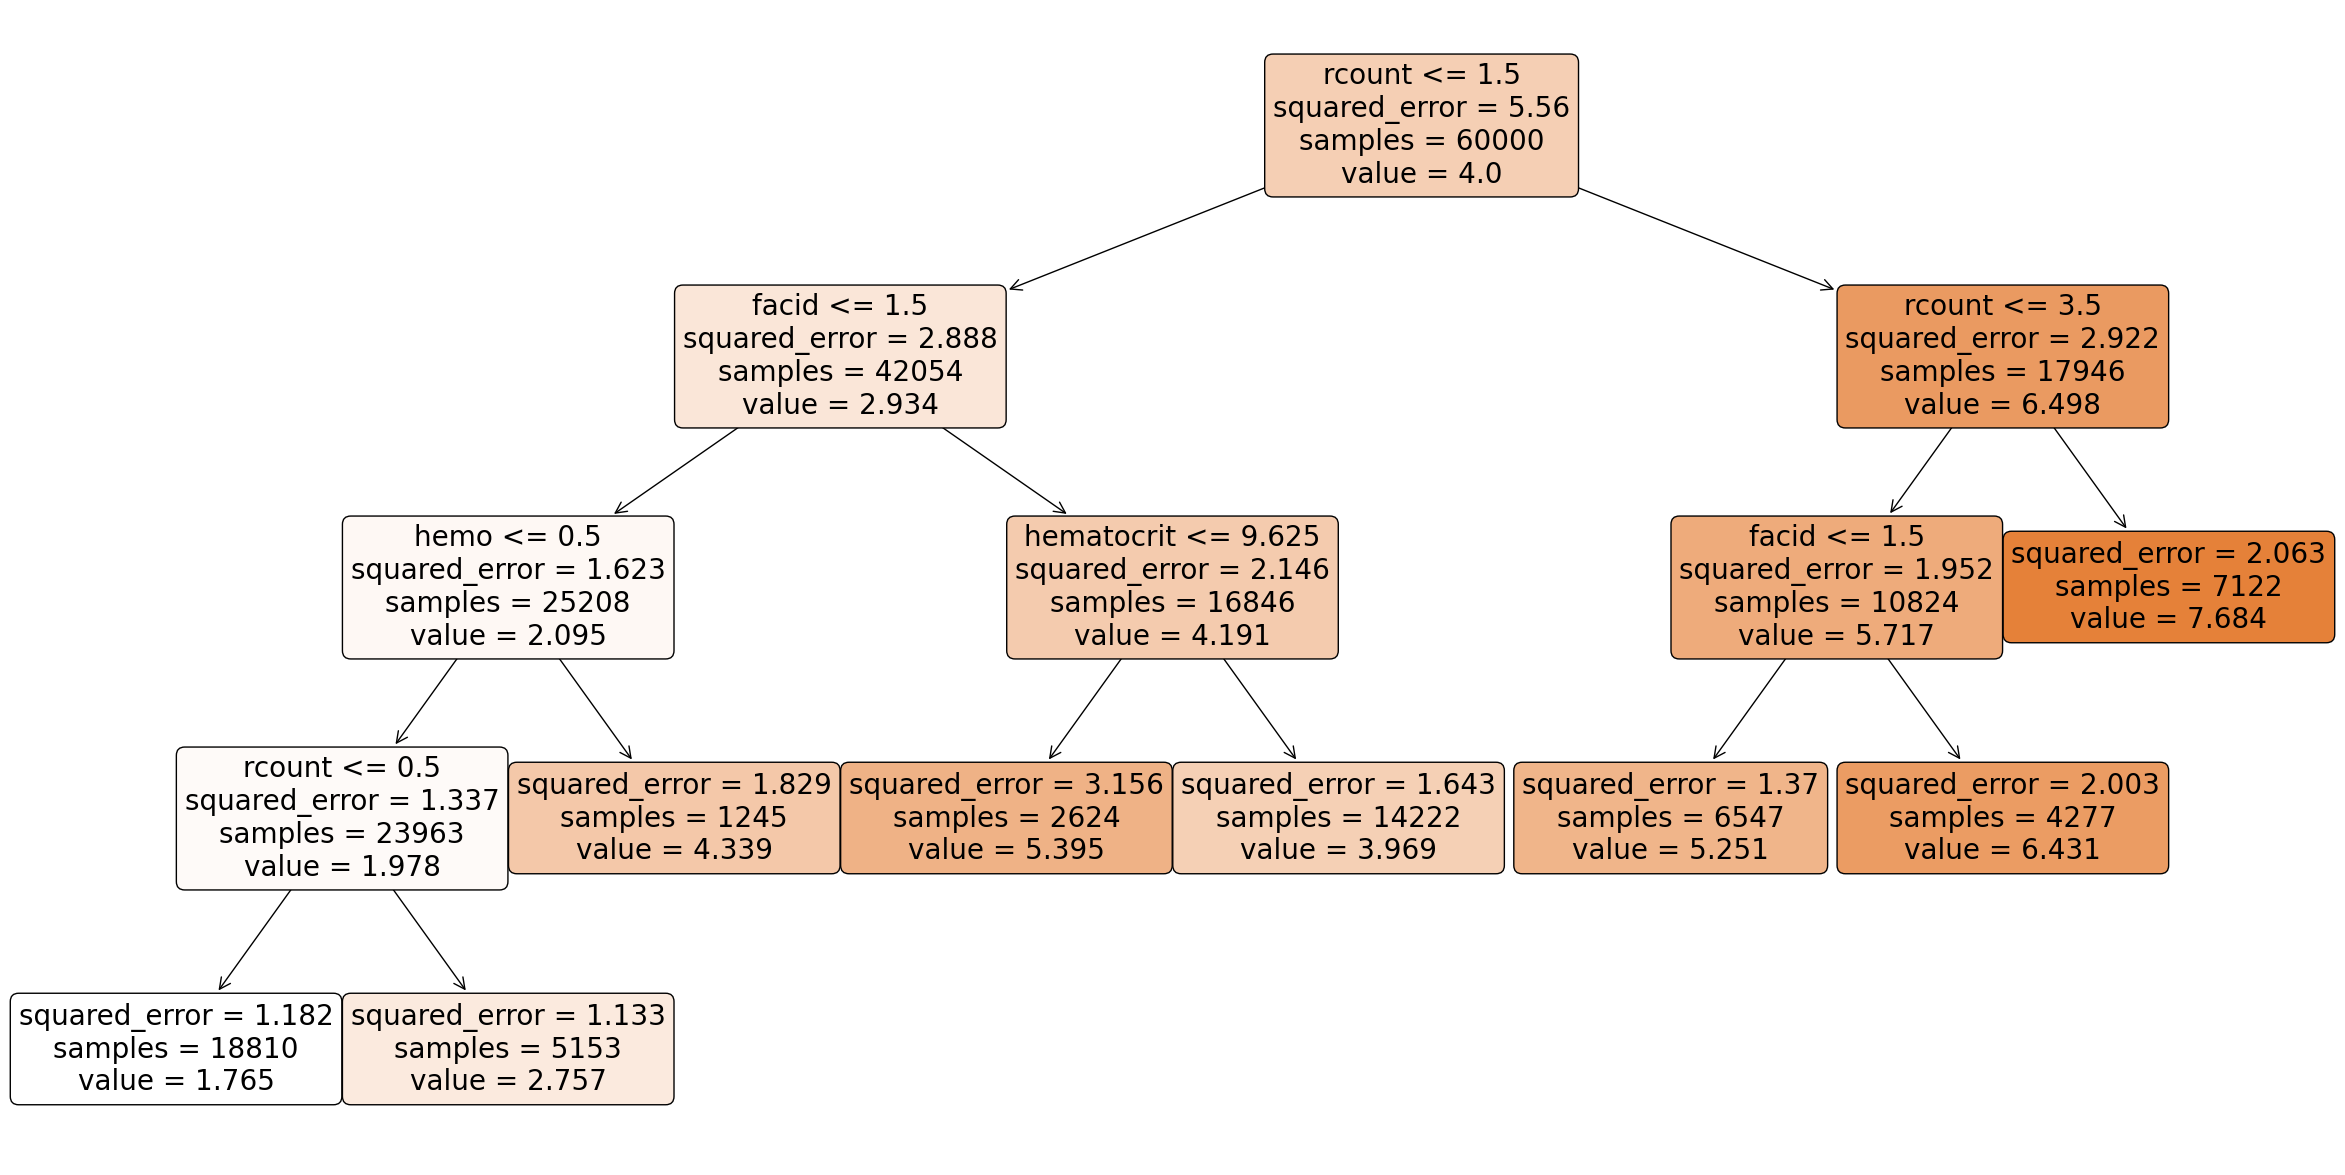

In [18]:
# Crea un albero decisionale per la regressione
tree = DecisionTreeRegressor(max_depth= 5, ccp_alpha=0.05, min_samples_split=4, random_state=0)
tree.fit(xtree_train, ytree_train)

y_pred = tree.predict(xtree_test)

# Calcola MAE, MSE e RMSE
mae = mean_absolute_error(ytree_test, y_pred)
mse = mean_squared_error(ytree_test, y_pred)
rmse = sqrt(mse)

# Aggiungi i calcoli alla lista 'elenco_modelli'
elenco_modelliML.append(('TREE', tree))

# Crea una figura
plt.figure(figsize=(30,15))

# Disegna l'albero
plot_tree(tree, max_depth=5, filled=True, rounded=True, feature_names=features)

# Mostra il plot
plt.show()

# Definizione architettura Random Forest

In [19]:
forest = RandomForestRegressor()

forest.set_params(n_estimators=100, max_depth=10)

forest.fit(xtree_train, ytree_train)

y_pred = forest.predict(xtree_test)

# Calcola MAE, MSE e RMSE
mae = mean_absolute_error(ytree_test, y_pred)
mse = mean_squared_error(ytree_test, y_pred)
rmse = sqrt(mse)

# Aggiungi i calcoli alla lista 'elenco_modelli'
elenco_modelliML.append(('FOREST', forest))

# Definizione architettura Ensemble

In [20]:
# Crea i modelli individuali
tree1 = DecisionTreeRegressor(max_depth=5, ccp_alpha=0.05, min_samples_split=4, random_state=0)
linear = LinearRegression()
bayes = BayesianRidge()

# Crea il modello di ensemble
ensemble = VotingRegressor(estimators=[('tree', tree1), ('linear', linear), ('bayes', bayes)])

# Allena il modello utilizzando i dati di addestramento
ensemble.fit(xtree_train, ytree_train)

y_pred = ensemble.predict(xtree_test)

# Calcola MAE, MSE e RMSE
mae = mean_absolute_error(ytree_test, y_pred)
mse = mean_squared_error(ytree_test, y_pred)
rmse = sqrt(mse)

# Aggiungi i calcoli alla lista 'elenco_modelli'
elenco_modelliML.append(('ENSEMBLE', ensemble))


# Prestazione dei modelli di apprendimento automatico

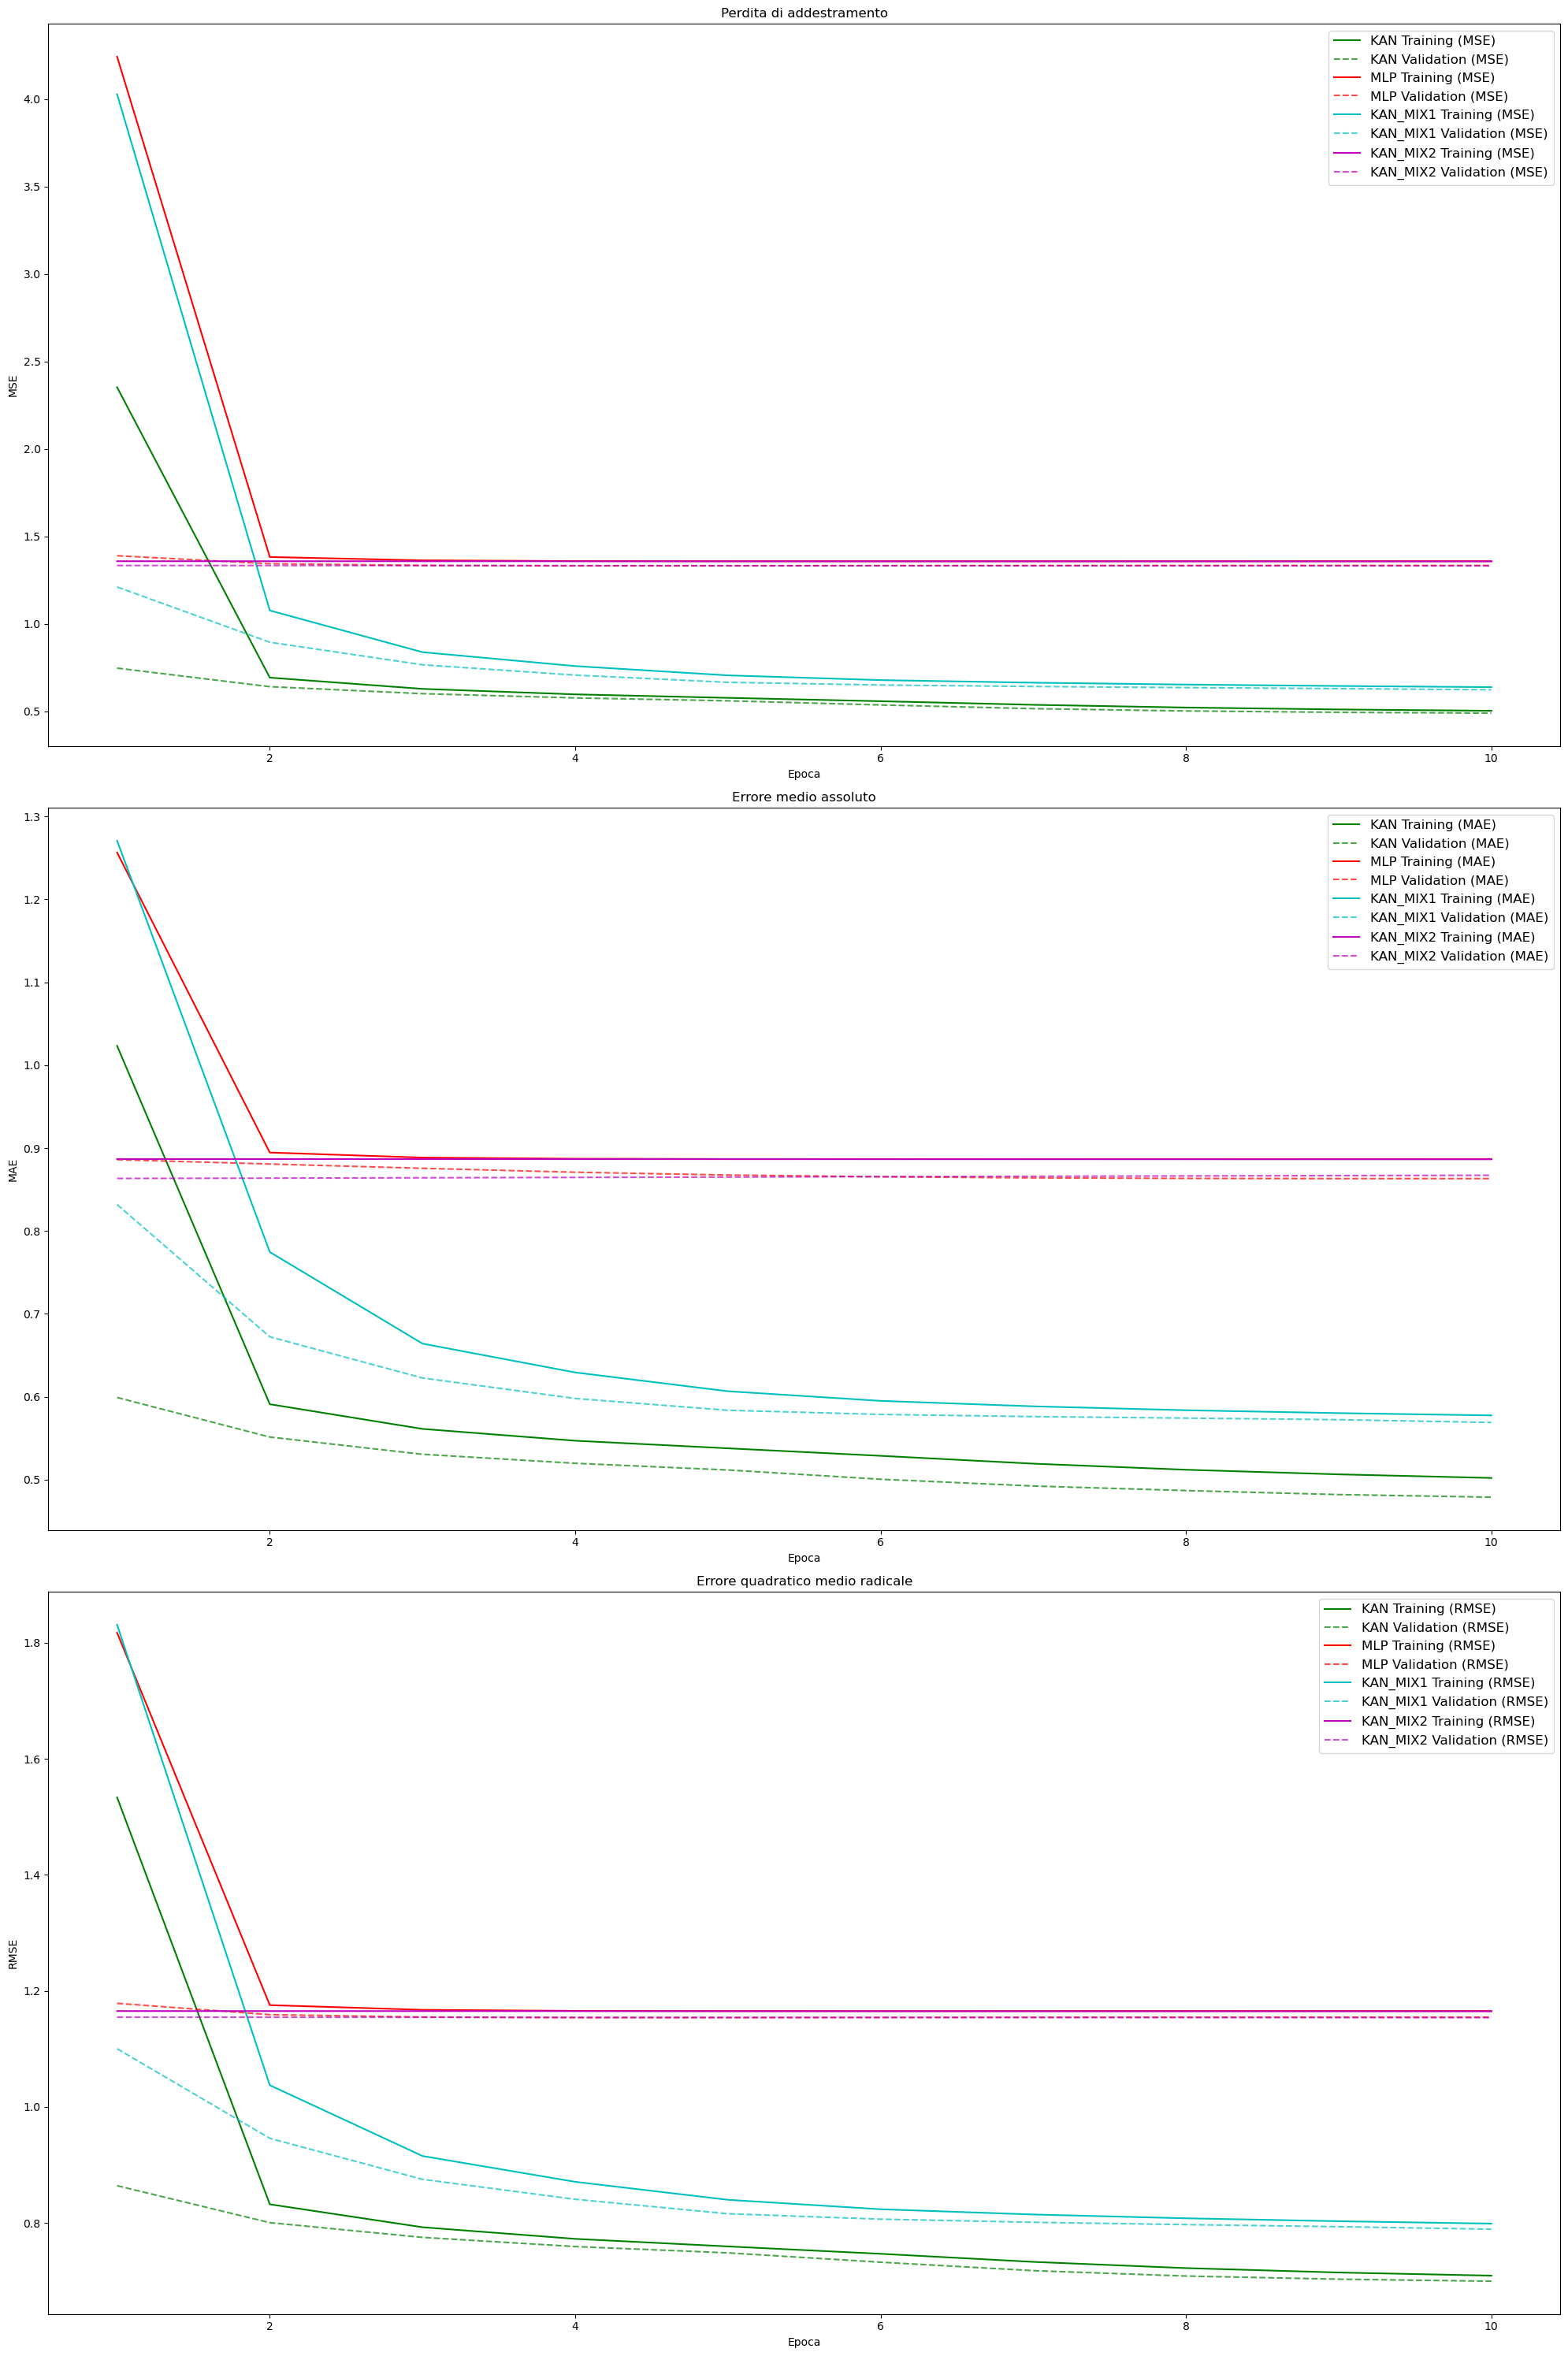

In [21]:
# Crea una lista di colori
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'purple']

plt.figure(figsize=(20, 30))
i=0


for model_name, history in histories:
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history['mae']
    val_mae = history.history['val_mae']
    rmse = history.history['rmse']
    val_rmse = history.history['val_rmse']
    i += 1
    epochs = range(1, len(loss) + 1)

    # Usa lo stesso colore per il training e il validation set di ogni modello
    color = colors[i % len(colors)]

    plt.subplot(3, 1, 1)
    plt.plot(epochs, loss, color, label=f'{model_name} Training (MSE)') 
    plt.plot(epochs, val_loss, color+'--', alpha=0.7, label=f'{model_name} Validation (MSE)') 
    plt.title('Perdita di addestramento')
    plt.xlabel('Epoca')
    plt.ylabel('MSE')
    plt.legend(fontsize='large')

    plt.subplot(3, 1, 2)
    plt.plot(epochs, mae, color, label=f'{model_name} Training (MAE)') 
    plt.plot(epochs, val_mae, color+'--', alpha=0.7, label=f'{model_name} Validation (MAE)') 
    plt.title('Errore medio assoluto')
    plt.xlabel('Epoca')
    plt.ylabel('MAE')
    plt.legend(fontsize='large')

    plt.subplot(3, 1, 3)
    plt.plot(epochs, rmse, color, label=f'{model_name} Training (RMSE)') 
    plt.plot(epochs, val_rmse, color+'--', alpha=0.7, label=f'{model_name} Validation (RMSE)') 
    plt.title('Errore quadratico medio radicale')
    plt.xlabel('Epoca')
    plt.ylabel('RMSE')
    plt.legend(fontsize='large')

plt.tight_layout()
plt.show()


# Analisi equità di genere

Abbiamo valutato varie metriche dei vari modelli per l'attributo gender che rappresenta un attributo sensibile

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step


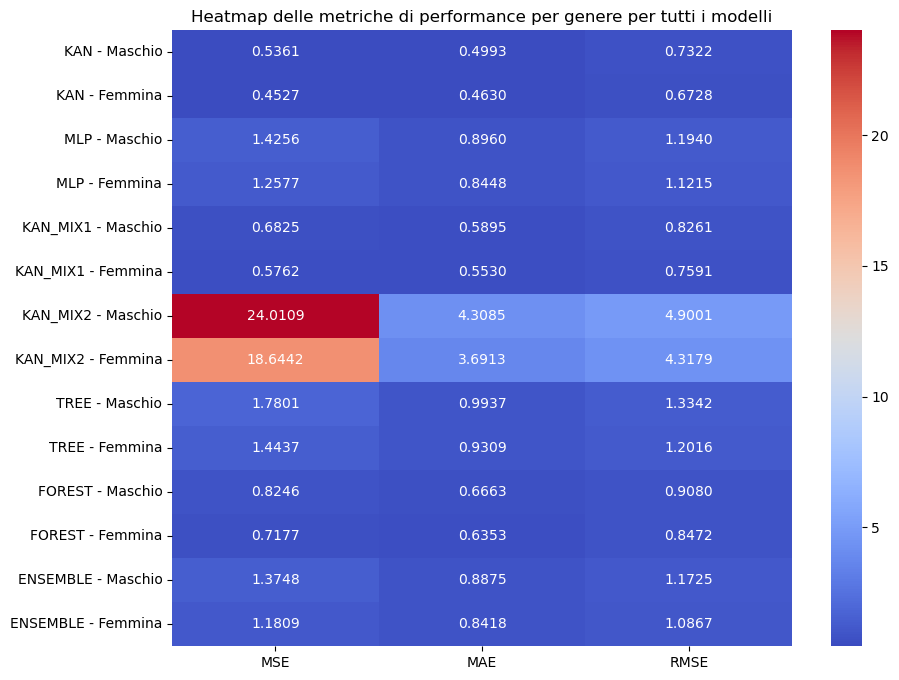

In [22]:
# Definizione delle categorie e sottogruppi
CATEGORY = 2  # indice dell'attributo "gender" nel tuo dataset
SUBGROUPS = [0, 1]  # 0 per maschio, 1 per femmina
SUBGROUPSML = ['M', 'F']  # 0 per maschio, 1 per femmina

# Creazione di un dizionario per memorizzare i risultati
all_results = {}

# Per ogni modello nella tua lista 'elenco_modelli'
for model_name, model in elenco_modelli:
    results = {}
    for sg in SUBGROUPS: #per ogni gruppo nell'elenco dei sottogruppi
        
        # Filtraggio del dataset di test per il sottogruppo corrente
        subgroup_indices = x_test[:, CATEGORY] == sg
        features1 = x_test[subgroup_indices]
        labels = y_test[subgroup_indices]
        
        # Calcolo delle previsioni del modello sul sottogruppo corrente
        predictions = model.predict(features1)
        
        # Calcolo delle metriche personalizzate per ciascun sottogruppo
        mse_value = tf.keras.metrics.MeanSquaredError()(labels, predictions).numpy()
        mae_value = tf.keras.metrics.MeanAbsoluteError()(labels, predictions).numpy()
        rmse_value = np.sqrt(mse_value)
        
        # Memorizzazione dei risultati
        results[sg] = [mse_value, mae_value, rmse_value]

    # Aggiungi i risultati di questo modello ai risultati totali
    all_results[model_name] = results

for model_name, model in elenco_modelliML:
    results = {}  # Inizializzazione di `results` per ogni modello ML
    for sg in SUBGROUPS:  # per ogni gruppo nell'elenco dei sottogruppi
        # Filtraggio del dataset di test per il sottogruppo corrente
        subgroup_indices = xtree_test.iloc[:, CATEGORY] == sg
        
        features1 = xtree_test[subgroup_indices]
        labels = ytree_test[subgroup_indices]
        
        # Calcolo delle previsioni del modello sul sottogruppo corrente
        predictions = model.predict(features1)
        
        # Calcolo delle metriche personalizzate per ciascun sottogruppo
        mse_value = mean_squared_error(labels, predictions)
        mae_value = mean_absolute_error(labels, predictions)
        rmse_value = np.sqrt(mse_value)
        
        # Memorizzazione dei risultati
        results[sg] = [mse_value, mae_value, rmse_value]
    
    # Aggiungi i risultati di questo modello ai risultati totali
    all_results[model_name] = results



# Creazione di un DataFrame per visualizzare le metriche di performance di tutti i modelli
df = pd.DataFrame()

for model_name, results in all_results.items():
    temp_df = pd.DataFrame(results, index=['MSE', 'MAE', 'RMSE'])
    temp_df.columns = [f'{model_name} - Maschio', f'{model_name} - Femmina']
    df = pd.concat([df, temp_df], axis=1)

# Conversione dei dati in float
df = df.astype(float)

# Trasposizione del DataFrame per invertire righe e colonne
df = df.transpose()

# Calcolo dei valori minimi e massimi per la scala di colori
vmin = df.min().min()
vmax = df.max().max()

# Creazione della heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt=".4f", vmin=vmin, vmax=vmax)
plt.title('Heatmap delle metriche di performance per genere per tutti i modelli')
plt.show()



# Trasparenza algoritmica

## Feature importance

Il metodo di trasparenza algoritmica "Feature Importance" valuta l'importanza di ciascuna caratteristica di un dataset nel contribuire al modello predittivo. Generalmente, questa valutazione viene effettuata misurando l'impatto della rimozione o della permutazione di una caratteristica sulle performance del modello.

In [23]:

# Lista delle caratteristiche
def calculate_feature_importance(model, x_val, y_val):
    # Calcola l'importanza delle caratteristiche
    results = permutation_importance(model, x_val, y_val, scoring='neg_mean_squared_error')
    # Ottieni l'importanza delle caratteristiche
    importance = results.importances_mean
    # Crea un dizionario con le caratteristiche e la loro importanza
    feature_importance = dict(zip(features, importance))
    return feature_importance


def calculate_feature_importanceML(model, x_val, y_val):
    # Verifica se il modello ha l'attributo 'feature_importances_'
    if hasattr(model, 'feature_importances_'):
        # Utilizza l'attributo 'feature_importances_' per i modelli basati su alberi
        importance = model.feature_importances_
    else:
        # Altrimenti, utilizza la 'permutation_importance'
        results = permutation_importance(model, x_val, y_val, scoring='neg_mean_squared_error')
        importance = results.importances_mean
    # Crea un dizionario con le caratteristiche e la loro importanza
    feature_importance = dict(zip(features, importance))
    return feature_importance


caratteristiche = []
for nome, modello in elenco_modelli:
    caratteristiche.append((nome, calculate_feature_importance(modello, x_test, y_test)))

for nome, modello in elenco_modelliML:
    caratteristiche.append((nome, calculate_feature_importanceML(modello, xtree_test, ytree_test)))



def stampa_importanza_caratteristiche(caratteristiche):
    for nome_modello, importanza_caratteristiche in caratteristiche:
        print(f"Modello: {nome_modello}")
        totale = 0
        for valus in importanza_caratteristiche.values():
            totale += abs(valus)
        
        for caratteristica, importanza in importanza_caratteristiche.items():
            print(f"Caratteristica: {caratteristica}, Importanza: {((importanza / totale)):.2f}")
        print("\n")

stampa_importanza_caratteristiche(caratteristiche)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
625/625 ━━━

Stampiamo graficamente i risultati della feature importance:

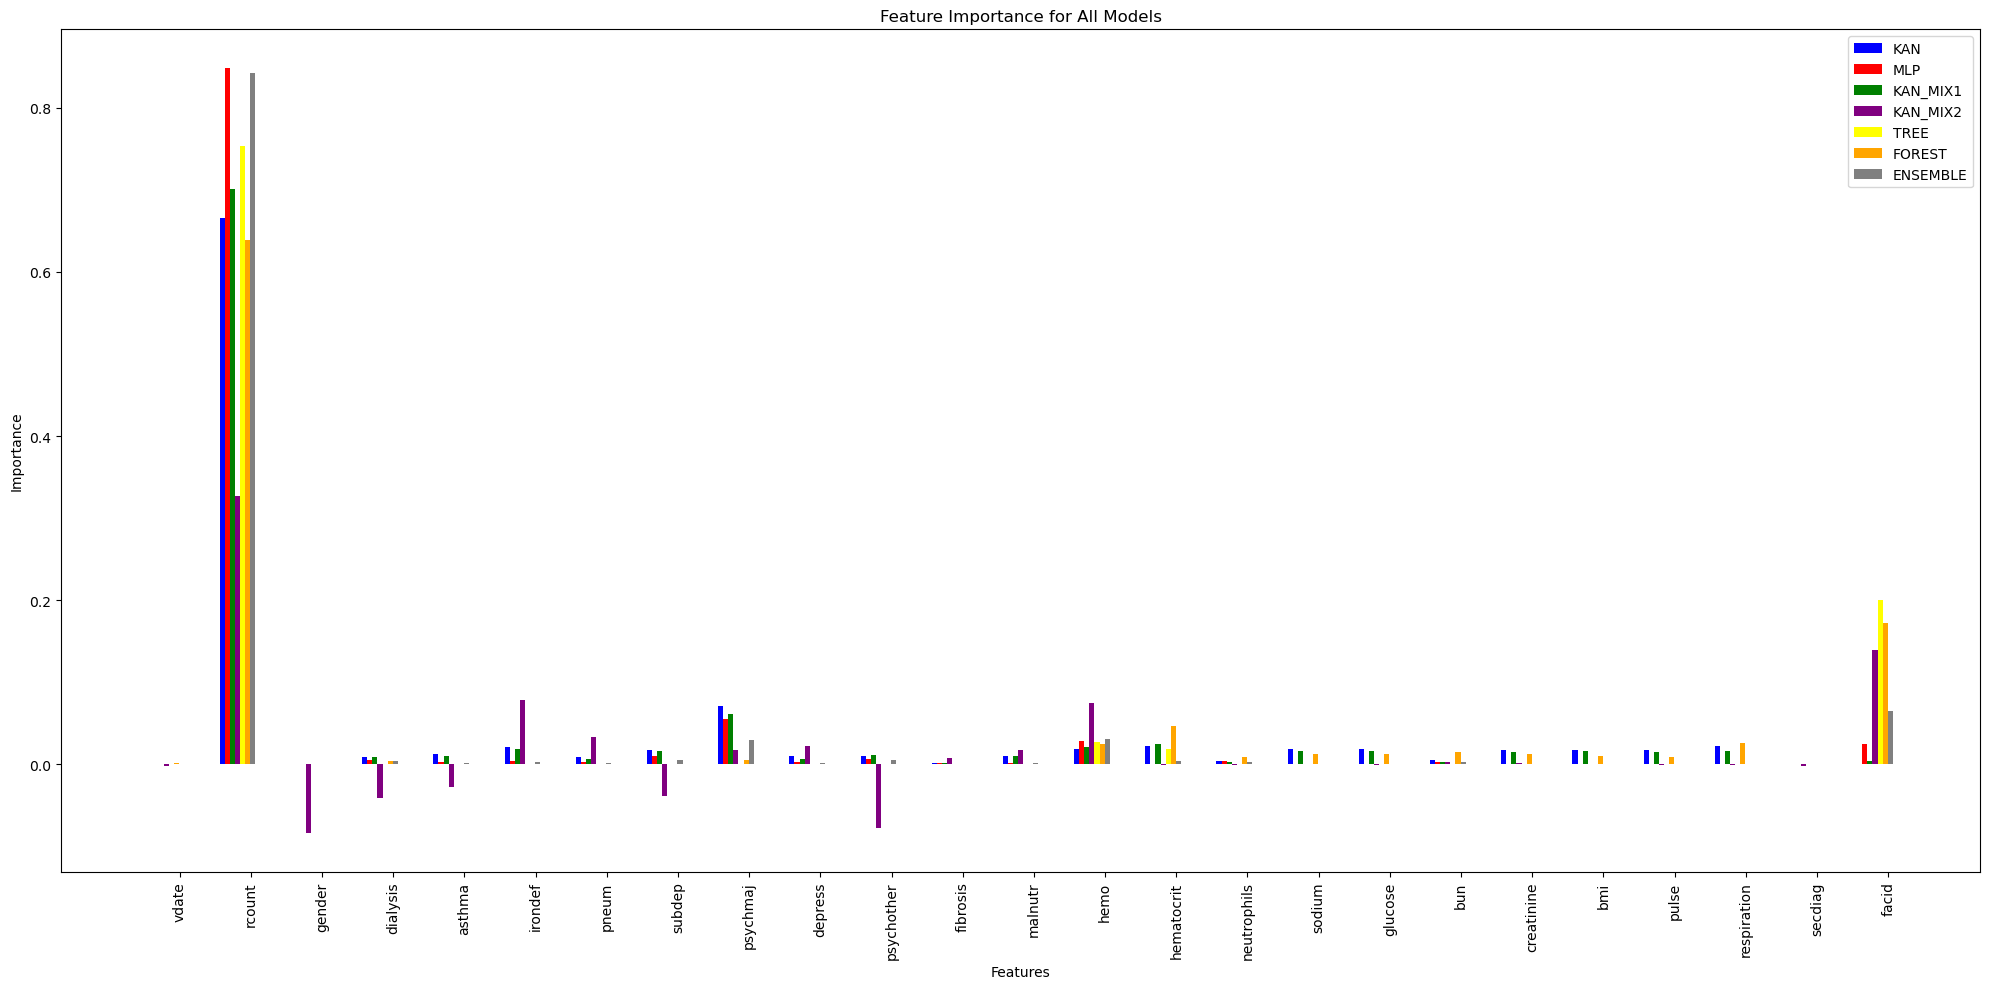

In [24]:
# Inizializza i dizionari per l'importanza delle caratteristiche
importanze = {}

# Calcola l'importanza delle caratteristiche per ogni modello
for nome, importanza in caratteristiche:
    importanze[nome] = {}
    totale = sum(abs(imp) for imp in importanza.values())
    for feature, importance in importanza.items():
        importanze[nome][feature] = importance / totale

# Crea le etichette per l'asse x
features = list(importanze[list(importanze.keys())[0]].keys())
x = np.arange(len(features))

# Crea un grafico a barre con dimensioni personalizzate
fig, ax = plt.subplots(figsize=(20, 10))  # Modifica le dimensioni qui

# Calcola la larghezza delle barre in base al numero di modelli
bar_width = 0.5 / len(importanze)

# Crea le barre per l'importanza delle caratteristiche per ogni modello
colors = ['blue', 'red', 'green', 'purple', 'yellow', 'orange', 'grey']  
for i, (nome, importanza) in enumerate(importanze.items()):
    ax.bar(x - 0.4 + i * bar_width, list(importanza.values()), bar_width, label=nome, color=colors[i % len(colors)])

# Aggiungi le etichette, il titolo e la legenda
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Feature Importance for All Models')
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=90)

ax.legend()

# Mostra il grafico
plt.tight_layout()
plt.show()

# LIME

Il metodo LIME (Local Interpretable Model-agnostic Explanations) è una tecnica di trasparenza algoritmica che spiega le previsioni di modelli complessi tramite modelli interpretabili e locali. LIME perturba i dati di input generando un set di dati simili e valuta le predizioni del modello su questi dati perturbati. Successivamente, LIME costruisce un modello interpretabile (ad esempio, una regressione lineare) sulle predizioni del modello complesso solo per l'area locale intorno all'istanza di interesse. Questo approccio permette di comprendere come il modello complesso prende decisioni per specifici campioni, rendendo le sue predizioni più comprensibili e trasparenti.

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


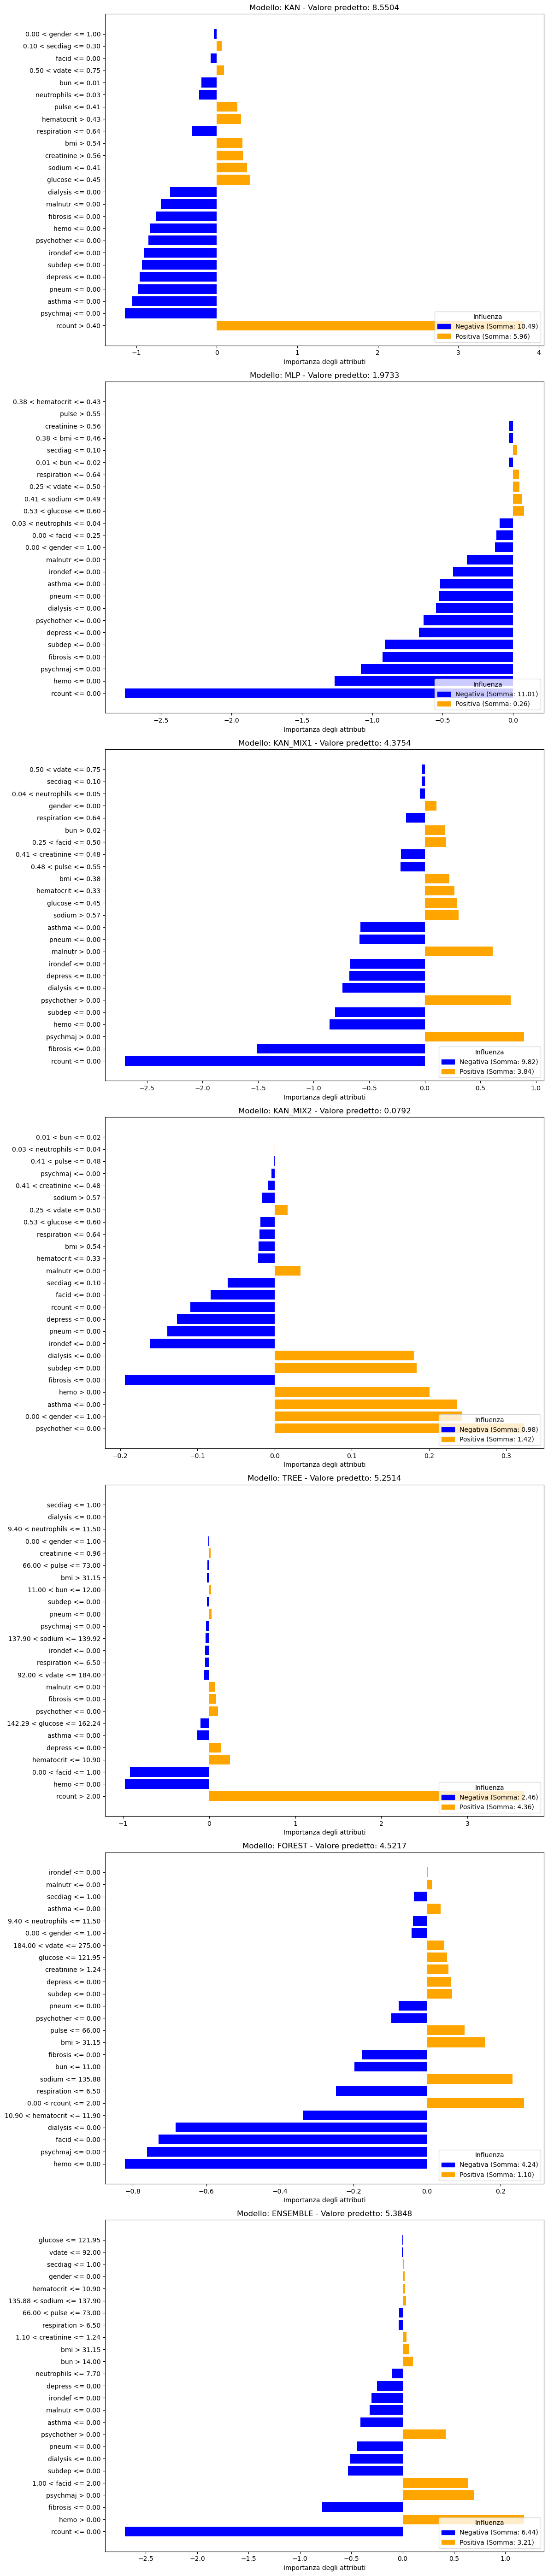

In [25]:
def check_and_reshape_data(X):
    if X.ndim == 1:
        return X.reshape(-1, 1)
    elif X.ndim > 2:
        return X.reshape(X.shape[0], -1)
    return X

def check_and_convert_data(X):
    if isinstance(X, pd.DataFrame):
        return X.values
    elif hasattr(X, 'numpy'):
        return X.numpy()
    return X

def apply_lime(model, X_train, X_test):
    X_train_np = X_train.values if isinstance(X_train, pd.DataFrame) else X_train.numpy() if hasattr(X_train, 'numpy') else X_train
    X_test_np = X_test.values if isinstance(X_test, pd.DataFrame) else X_test.numpy() if hasattr(X_test, 'numpy') else X_test

    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train_np,
        feature_names=features,
        class_names=['target'],
        mode='regression'
    )
    
    def model_predict(input_data):
        input_data = input_data.reshape(1, -1) if input_data.ndim == 1 else input_data
        if isinstance(X_train, pd.DataFrame):
            input_data = pd.DataFrame(input_data, columns=X_train.columns)
        elif hasattr(X_train, 'numpy'):
            input_data = tf.convert_to_tensor(input_data)
        return model.predict(input_data)
    
    instance = X_test_np[random.randint(0, len(X_test_np)-1)]
    explanation = explainer.explain_instance(instance, model_predict, num_features=len(features))
    
    prediction = model_predict(instance.reshape(1, -1))
    predicted_value = prediction[0] if isinstance(prediction, np.ndarray) else prediction
    
    return explanation.as_list(), predicted_value

def plot_lime_results(all_results):
    n_models = len(all_results)
    if n_models == 0:
        return
    
    fig, axs = plt.subplots(n_models, 1, figsize=(12, 8*n_models), squeeze=False)
    
    for i, (model_name, feature_importance, predicted_value) in enumerate(all_results):
        attributi, importances = zip(*feature_importance)
        colors = ['blue' if imp < 0 else 'orange' for imp in importances]
        
        ax = axs[i, 0]
        bars = ax.barh(range(len(attributi)), importances, color=colors)
        ax.set_yticks(range(len(attributi)))
        ax.set_yticklabels(attributi)
        ax.set_xlabel('Importanza degli attributi')
        
        # Gestione del valore predetto come array o scalare
        if isinstance(predicted_value, np.ndarray):
            predicted_value_str = ', '.join([f'{v:.4f}' for v in predicted_value.flatten()])
        else:
            predicted_value_str = f'{predicted_value:.4f}'
        
        ax.set_title(f'Modello: {model_name} - Valore predetto: {predicted_value_str}')
        ax.set_facecolor('white')
        
        # Calcola la somma dei valori positivi e negativi
        positive_sum = sum(abs(imp) for imp in importances if imp > 0)
        negative_sum = sum(abs(imp) for imp in importances if imp < 0)
        
        # Aggiungi una leggenda con le somme
        handles = [plt.Rectangle((0,0),1,1, color=color) for color in ['blue', 'orange']]
        ax.legend(handles, [f'Negativa (Somma: {negative_sum:.2f})', 
                            f'Positiva (Somma: {positive_sum:.2f})'], 
                  title='Influenza', loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
# Raccoglie i risultati di LIME per tutti i modelli
all_results = []

# Applica LIME a tutti i modelli in elenco_modelli
for name, model in elenco_modelli:
    try:
        feature_importance, predicted_value = apply_lime(model, x_train, x_test)
        all_results.append((name, feature_importance, predicted_value))
    except Exception as e:
        print(f"Errore nell'applicazione di LIME al modello {name}:")
        import traceback
        traceback.print_exc()

# Applica LIME a tutti i modelli in elenco_modelliML
for name, model in elenco_modelliML:
    try:
        feature_importance, predicted_value = apply_lime(model, xtree_train, xtree_test)
        all_results.append((name, feature_importance, predicted_value))
    except Exception as e:
        print(f"Errore nell'applicazione di LIME al modello {name}:")
        import traceback
        traceback.print_exc()

# Visualizza i risultati
if all_results:
    plot_lime_results(all_results)
else:
    print("Nessun risultato da visualizzare.")

## Grafico Architettura KAN

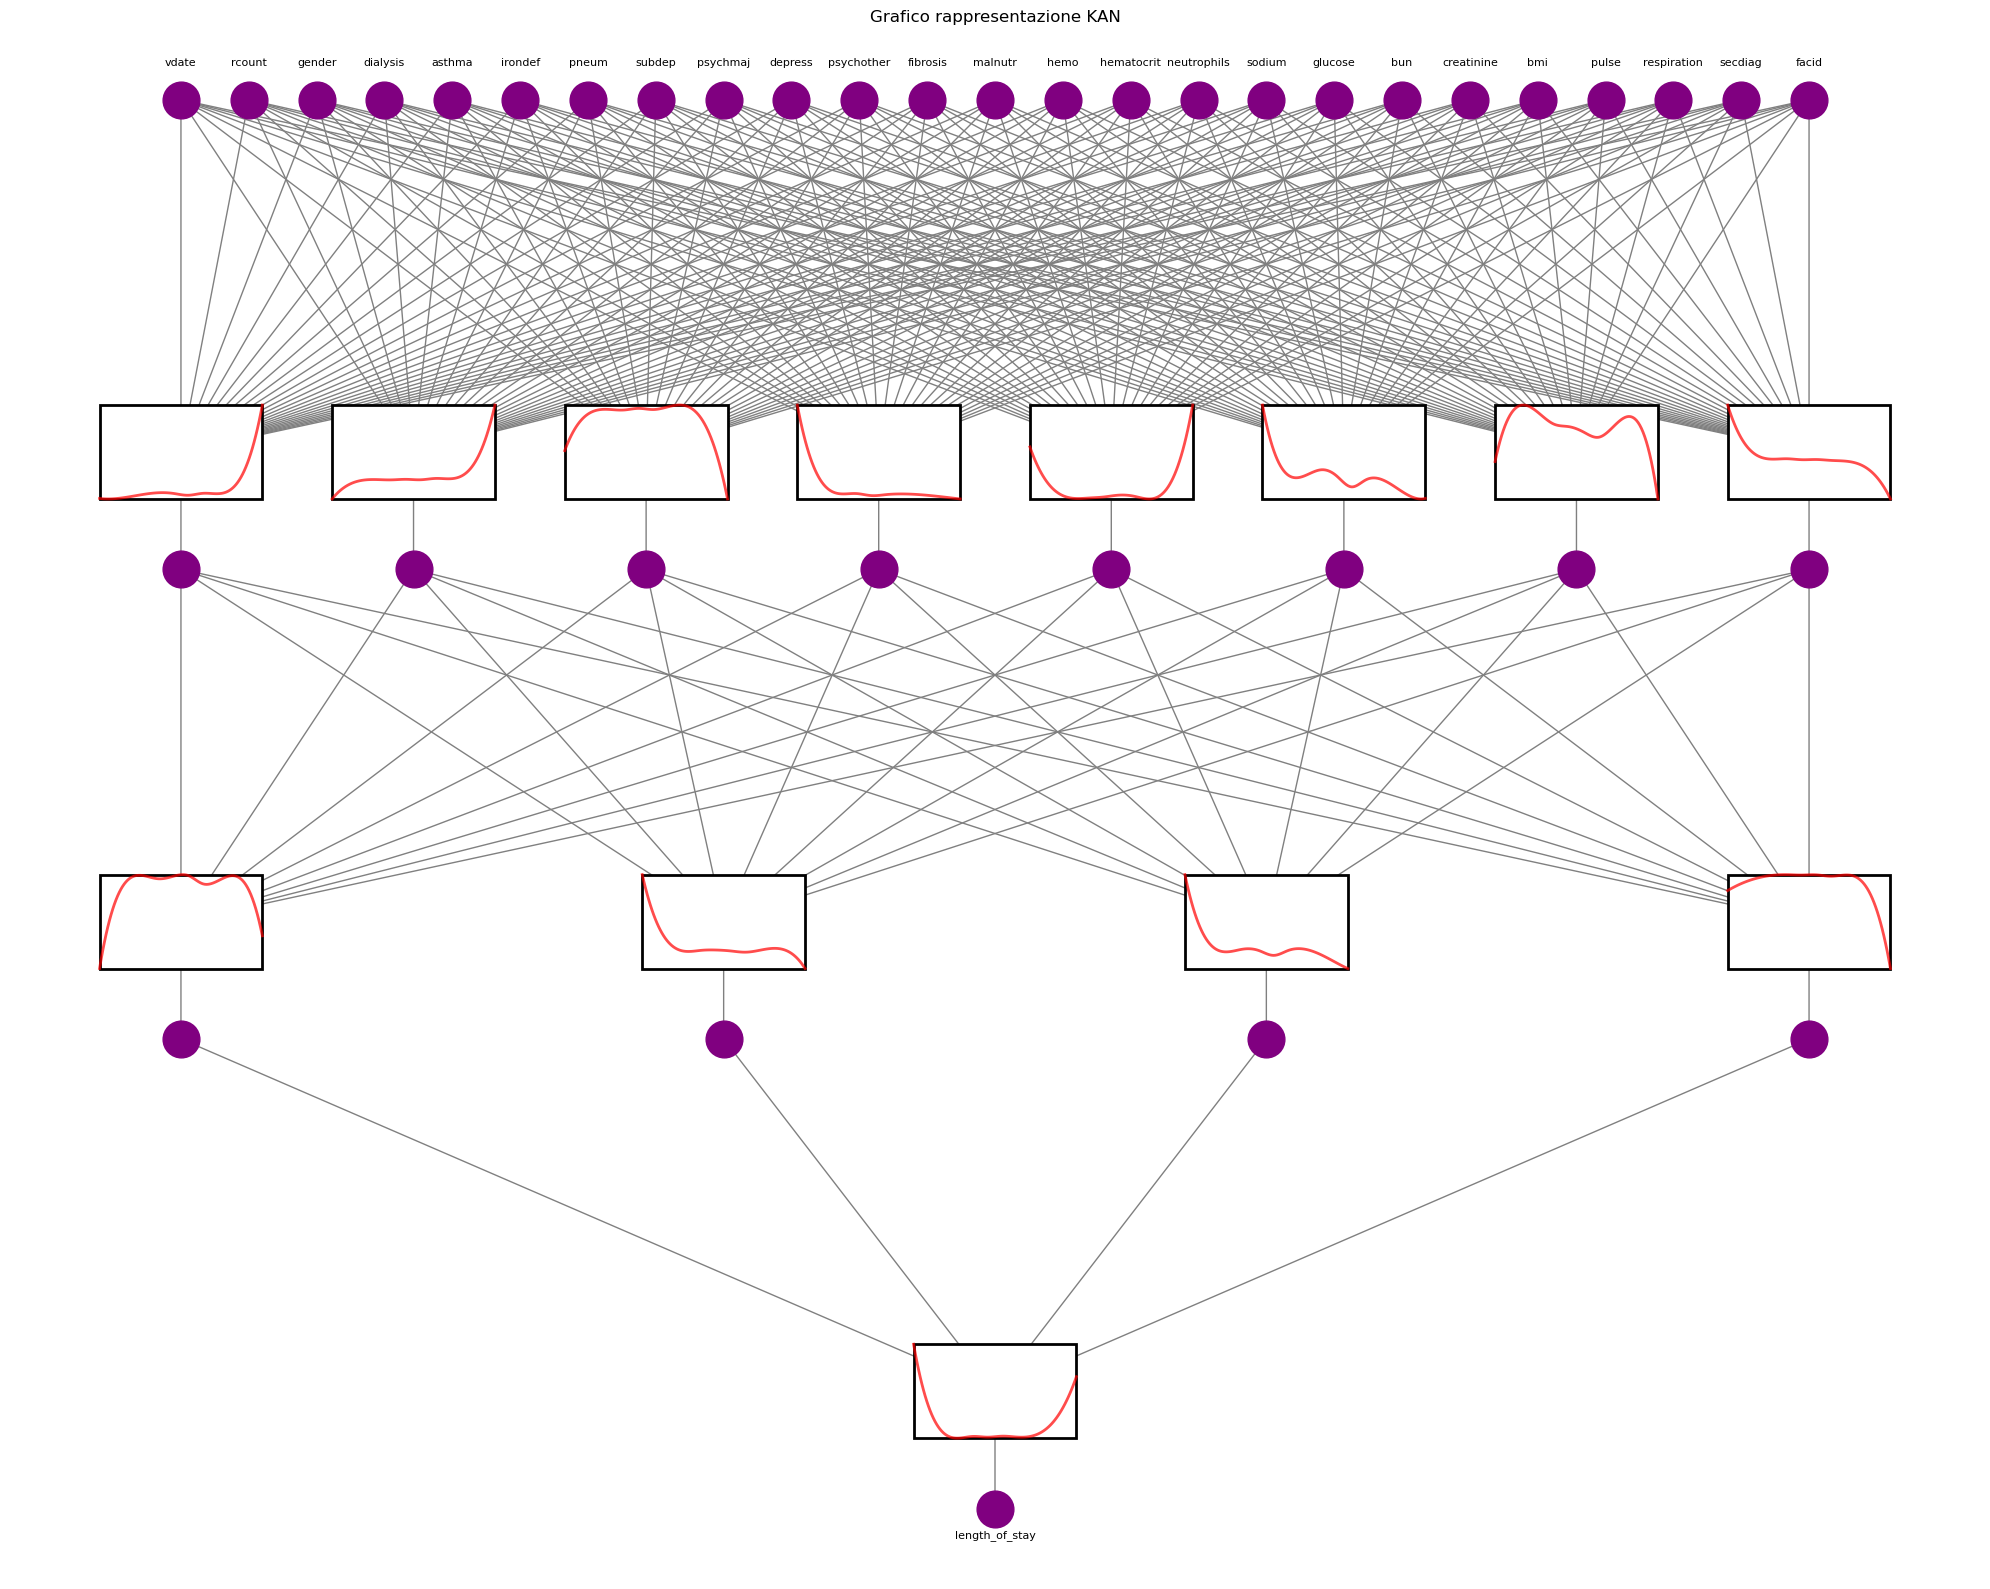

In [26]:
def get_all_splines_from_model(model):
    all_splines = []
    for layer in model.layers:
        if isinstance(layer, DenseKAN):
            all_splines.extend(layer.spline_list)
    return all_splines

def create_kan_tree_from_model(model, features):
    G = nx.DiGraph()
    
    # Add input nodes
    for i, feature in enumerate(features):
        G.add_node(feature, layer=0, pos=(i / (len(features) - 1) if len(features) > 1 else 0.5, 0))
    
    # Add hidden and output layers
    total_layers = len(model.layers)
    for layer_idx, layer in enumerate(model.layers):
        units = layer.units
        for j in range(units):
            x_pos = j / (units - 1) if units > 1 else 0.5
            G.add_node(f"h{layer_idx+1}_{j}", layer=layer_idx+1, pos=(x_pos, -(layer_idx+1) / (total_layers+1)))
        
        prev_layer_units = len(features) if layer_idx == 0 else model.layers[layer_idx-1].units
        for i in range(prev_layer_units):
            for j in range(units):
                if layer_idx == 0:
                    G.add_edge(features[i], f"h{layer_idx+1}_{j}")
                else:
                    G.add_edge(f"h{layer_idx}_{i}", f"h{layer_idx+1}_{j}")
    
    return G

def draw_merged_edges(G, pos, ax, kan, edge_color='gray'):
    merge_points = []
    for target in G.nodes():
        in_edges = list(G.in_edges(target))
        if len(in_edges) > 1:
            target_pos = np.array(pos[target])
            merge_point = target_pos + np.array([0, (pos[in_edges[0][0]][1] - target_pos[1]) / 4])
            merge_points.append(merge_point)
            
            for source, _ in in_edges:
                start = np.array(pos[source])
                ax.annotate("", xy=merge_point, xytext=start, arrowprops=dict(arrowstyle="-", color=edge_color, connectionstyle="arc3,rad=0.0"), zorder=1)
            
            ax.annotate("", xy=target_pos, xytext=merge_point, arrowprops=dict(arrowstyle="-", color=edge_color), zorder=1)
    
    spline_collection = get_all_splines_from_model(kan)
    square_size = 0.1  # Fixed square size
    for i, point in enumerate(merge_points):
        if i < len(spline_collection):
            square = plt.Rectangle((point[0] - square_size/2, point[1] - square_size/4), square_size, square_size / 2, fill=True, facecolor='white', edgecolor='black', linewidth=2, zorder=2)
            ax.add_patch(square)
            
            # Draw B-spline within the square
            spl = spline_collection[i]
            xx = np.linspace(spl.t[0], spl.t[-1], 100)
            yy = spl(xx)
            
            # Normalize B-spline values to fit the square
            xx_norm = (xx - np.min(xx)) / (np.max(xx) - np.min(xx)) * square_size + (point[0] - square_size/2)
            yy_norm = (yy - np.min(yy)) / (np.max(yy) - np.min(yy)) * (square_size / 2) + (point[1] - square_size / 4)
            
            ax.plot(xx_norm, yy_norm, color='#FF0000', lw=2, alpha=0.7, zorder=3)
    
    return merge_points

# Create graph from model
G = create_kan_tree_from_model(kan, features)

# Setup plot
fig, ax = plt.subplots(figsize=(20, 16))
pos = nx.get_node_attributes(G, 'pos')

# Draw edges and squares with B-splines
merge_points = draw_merged_edges(G, pos, ax, kan)

# Draw nodes
node_collection = nx.draw_networkx_nodes(G, pos, node_size=700, node_color='purple', ax=ax)
node_collection.set_zorder(4)  # Set zorder for nodes

# Add labels
label_pos = {node: (x, y + 0.02) for node, (x, y) in pos.items()}
labels = {node: node if G.nodes[node]['layer'] == 0 else "" for node in G.nodes()}
label_collection = nx.draw_networkx_labels(G, label_pos, labels, font_size=8, ax=ax)

# Add "length_of_stay" label below the lowest node
lowest_node = min(pos.items(), key=lambda x: x[1][1])[0]
ax.text(pos[lowest_node][0], pos[lowest_node][1] - 0.015, "length_of_stay", fontsize=8, ha='center')

plt.title("Grafico rappresentazione KAN")
plt.axis('off')
plt.tight_layout()
plt.show()

# Confronto prestazioni modelli

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step


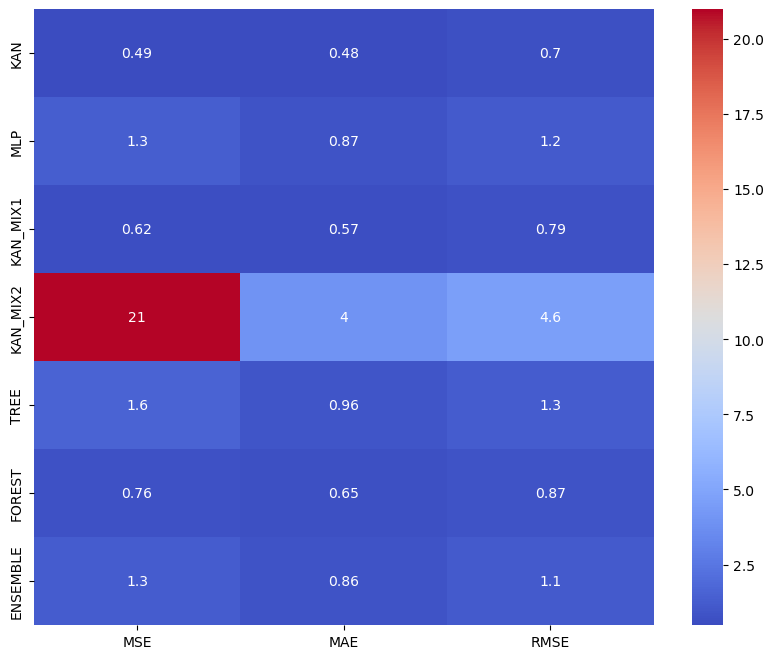

In [27]:

def calculate_metrics(model, X, y):
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    rmse = root_mean_squared_error(y, predictions)
    return mse, mae, rmse

def performance_heatmap(models, modelsML, X, y, x1, y1):
    metrics = ['MSE', 'MAE', 'RMSE']
    performance = {metric: [] for metric in metrics}
    model_names = []

    for model_name, model in models:
        mse, mae, rmse = calculate_metrics(model, X, y)
        performance['MSE'].append(mse)
        performance['MAE'].append(mae)
        performance['RMSE'].append(rmse)
        model_names.append(model_name)

    for model_name, model in modelsML:
        mse, mae, rmse = calculate_metrics(model, x1, y1)
        performance['MSE'].append(mse)
        performance['MAE'].append(mae)
        performance['RMSE'].append(rmse)
        model_names.append(model_name)

    df = pd.DataFrame(performance, index=model_names)
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, cmap='coolwarm')
    plt.show()

performance_heatmap(elenco_modelli, elenco_modelliML, x_test, y_test, xtree_test, ytree_test)


# Tuning (non è da tenere nel notebook, ma era piu comodo averlo direttamente qui)

In [28]:
if False:
    class MyHyperModel(HyperModel):
        def __init__(self, input_shape):
            self.input_shape = input_shape

        def build(self, hp):
            model = keras.Sequential()
            model.add(tf.keras.layers.Input(shape=self.input_shape))
            
            for i in range(hp.Int('num_layers', min_value=2, max_value=5)):
                model.add(DenseKAN(
                    units=hp.Int('units_' + str(i), min_value=1, max_value=32, step=1),
                    grid_size=hp.Int('grid_size_' + str(i), 3, 7),
                    spline_order=hp.Int('spline_order_' + str(i), 2, 4)
                ))
            
            model.add(DenseKAN(1))

            learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
            optimizer = hp.Choice('optimizer', ['adam', 'adagrad', 'rmsprop', 'adadelta'])
            
            if optimizer == 'adam':
                opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            elif optimizer == 'adagrad':
                opt = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
            elif optimizer == 'rmsprop':
                opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
            else:
                opt = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)

            model.compile(optimizer=opt,
                        loss='mean_absolute_error',
                        metrics=[
                            tf.keras.metrics.MeanSquaredError(name='mse'),
                            tf.keras.metrics.MeanAbsoluteError(name='mae'),
                            tf.keras.metrics.RootMeanSquaredError(name='rmse')
                        ])
            return model


    # Assumo che x_train, y_train siano già definiti
    hypermodel = MyHyperModel(input_shape=(numero_feature,))

    tuner = BayesianOptimization(
        hypermodel,
        objective='val_loss',
        max_trials=100,
        directory=r".\modelli_salvati",
        project_name='retina_kan'
    )

    tuner.search_space_summary()

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True
    )

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.7,
        patience=5,
        min_lr=1e-6
    )

    # K-Fold Cross Validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_indices, val_indices) in enumerate(kfold.split(x_train)):
        print(f"Fold {fold + 1}")
        train_indices = tf.convert_to_tensor(train_indices, dtype=tf.int32)
        val_indices = tf.convert_to_tensor(val_indices, dtype=tf.int32)
        
        x_train_fold, x_val_fold = tf.gather(x_train, train_indices), tf.gather(x_train, val_indices)
        y_train_fold, y_val_fold = tf.gather(y_train, train_indices), tf.gather(y_train, val_indices)

        tuner.search(x_train_fold, y_train_fold,
                    epochs=200,
                    validation_data=(x_val_fold, y_val_fold),
                    callbacks=[early_stopping, lr_scheduler])

    tuner.results_summary()
    best_model = tuner.get_best_models(num_models=1)[0]

    # Valutazione del modello migliore sul set di test
    test_loss, test_mse, test_mae, test_rmse = best_model.evaluate(x_test, y_test)
    print(f"Test Loss: {test_loss}")
    print(f"Test MSE: {test_mse}")
    print(f"Test MAE: {test_mae}")
    print(f"Test RMSE: {test_rmse}")

    # Salvataggio del modello migliore
    best_model.save('best_retina_kan_model.h5')

In [29]:
# Ottieni i migliori iperparametri
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Ottieni e stampa i nomi e i valori dei parametri
for param_name in best_hyperparameters.values.keys():
    print(f"{param_name}: {best_hyperparameters.get(param_name)}")


NameError: name 'tuner' is not defined

In [ ]:
# Ottieni i migliori iperparametri per i primi 10 modelli
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=10)

# Per ogni set di iperparametri
for i, hyperparameters in enumerate(best_hyperparameters):
    print(f"Modello {i+1}")
    # Ottieni e stampa i nomi e i valori dei parametri
    for param_name in hyperparameters.values.keys():
        print(f"{param_name}: {hyperparameters.get(param_name)}")
    print("\n")


NameError: name 'tuner' is not defined